## Implementation of Pairs Trading Strategy

 Load Data from yfinance

In [82]:
import pandas as pd
import numpy as np
import statsmodels 
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [83]:
# set the seed for random number generator
np.random.seed(104)

We start by generating 2 fake securities. Then we perform cumulative sum to get the value of X on each day.

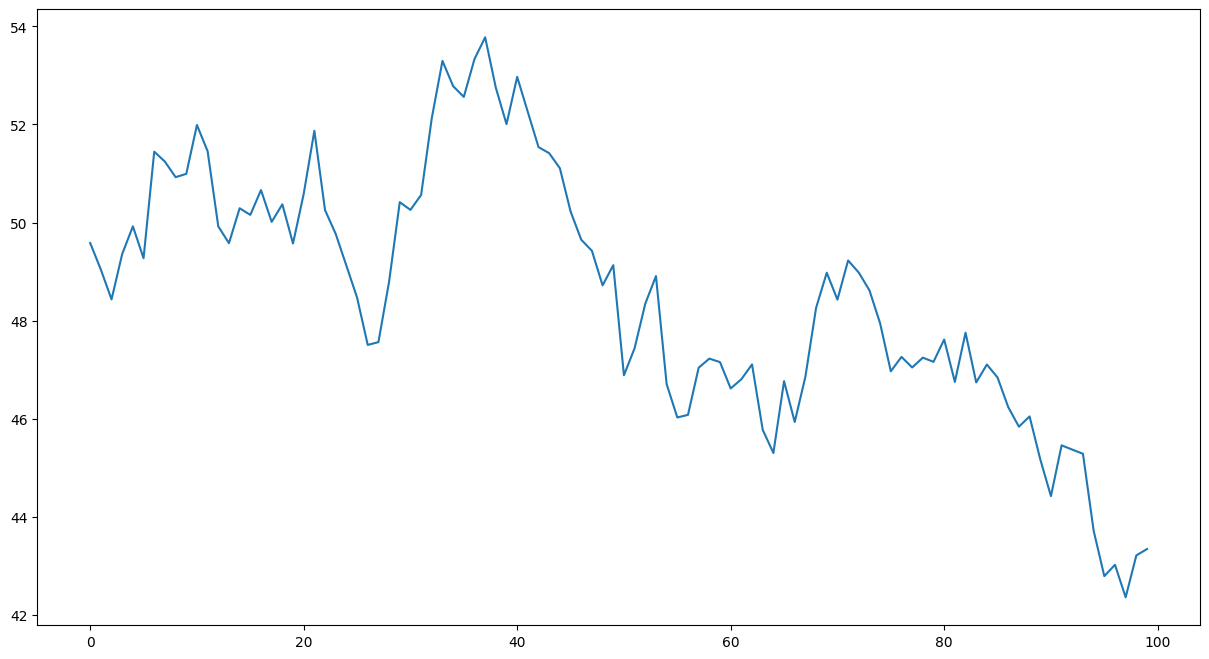

In [84]:
#generate daily returns 
Xreturns=np.random.normal(0,1,100)
#sum them and shift allthe prices up.
X=pd.Series(np.cumsum(Xreturns),name='X')+50
X.plot(figsize=(15,8))
plt.show()

Now we create Y. Y is supposed to have a deep economic link to X, so the price of Y should vary pretty similarly.

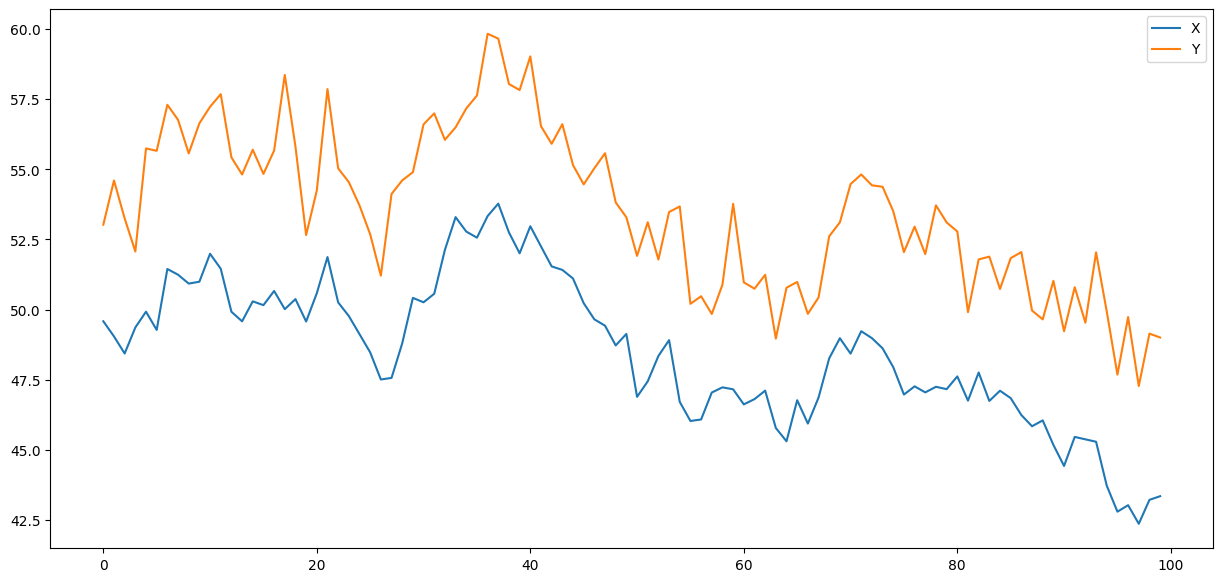

In [85]:
noise=np.random.normal(0,1,100)
Y=X+5+noise
Y.name='Y'
pd.concat([X,Y],axis=1).plot(figsize=(15,7))
plt.show()

### Cointegration

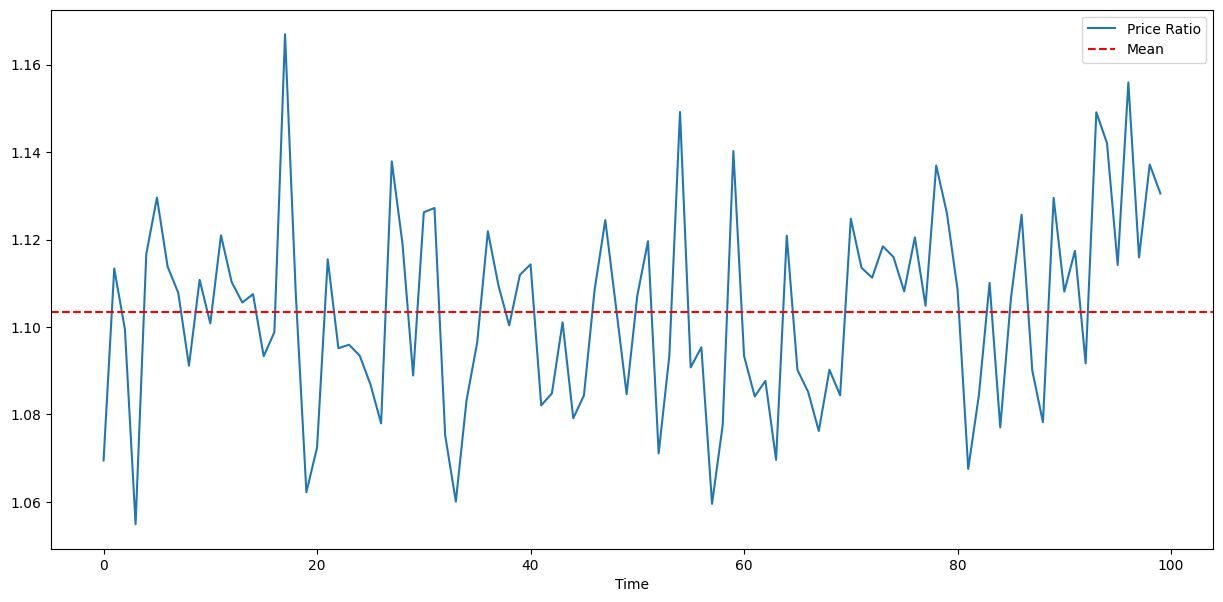

In [86]:
(Y/X).plot(figsize=(15,7))
plt.axhline((Y/X).mean(),color='red',linestyle='--')
plt.xlabel('Time')
plt.legend(['Price Ratio','Mean'])
plt.show()

In [87]:
'''
compute the p-value of the cointegration test will inform us as,
to whether the ratio between the 2 timeseries is stationary around,
its mean
'''
score,pvalue,_=coint(X,Y)

### Helping function to find cointegrated pairs that have substance behind them.

In [88]:
def find_coin_pairs(data):
    n=data.shape[1]
    score_matrix=np.zeros((n,n))
    pvalue_matrix=np.ones((n,n))
    keys=data.keys()
    pairs=[]
    for i in range(n):
        for j in range(i+1,n):
            s1=data[keys[i]]
            s2=data[keys[j]]
            result=coint(s1,s2)
            score=result[0]
            pvalue=result[1]
            score_matrix[i,j]=score
            pvalue_matrix[i,j]=pvalue
            if pvalue<0.05:
                pairs.append((keys[i],keys[j]))
    return score_matrix,pvalue_matrix,pairs            

Now Loading Data for our pairs trading

In [89]:
tickers=['AMD', 'NVDA', 'INTC', 'TXN', 'AVGO', 'QCOM',
    'MSFT', 'ADBE', 'ORCL', 'CRM', 'SAP',
    'IBM', 'HPQ', 'DELL', 'CSCO',
    'AAPL', 'EBAY', 'AMZN', 'META',
    'GOOGL', 'GOOG', 'INTU', 'NOW', 'PANW',
    'SPY']
df=yf.download(tickers,start='2015-01-01',auto_adjust=False)

[*********************100%***********************]  25 of 25 completed


In [90]:
df.head()

Price       Adj Close                                                 \
Ticker           AAPL       ADBE   AMD     AMZN      AVGO        CRM   
Date                                                                   
2015-01-02  24.237545  72.339996  2.67  15.4260  7.574802  58.528862   
2015-01-05  23.554745  71.980003  2.66  15.1095  7.453716  57.471703   
2015-01-06  23.556959  70.529999  2.63  14.7645  7.284191  56.513344   
2015-01-07  23.887278  71.110001  2.58  14.9210  7.480962  56.246593   
2015-01-08  24.805080  72.919998  2.61  15.0230  7.854823  57.886658   

Price                                             ...    Volume            \
Ticker           CSCO DELL       EBAY       GOOG  ...      META      MSFT   
Date                                              ...                       
2015-01-02  19.815611  NaN  21.054214  25.973845  ...  18177500  27913900   
2015-01-05  19.420879  NaN  20.878170  25.432404  ...  26452200  39673900   
2015-01-06  19.413696  NaN  20.608480  24.842955  ...  27399300  36447900   
2015-01-07  19.593124  NaN  20.574772  24.800392  ...  22045300  29114100   
2015-01-08  19.743843  NaN  21.129126  24.878592  ...  23961000  29645200   

Price                                                                   \
Ticker          NOW       NVDA      ORCL     PANW      QCOM        SAP   
Date                                                                     
2015-01-02  4079000  113680000  15070200  9902400   6662700   683600.0   
2015-01-05  4002500  197952000  18369400  8101200  12042800  1678800.0   
2015-01-06  4279500  197764000  19229500  8107200  11094000  1478900.0   
2015-01-07  3115000  321808000  13502200  7582800  10030700  1483100.0   
2015-01-08  3185500  283780000  17516900  4288800  10937200  1184700.0   

Price                           
Ticker            SPY      TXN  
Date                            
2015-01-02  121465900  4020100  
2015-01-05  169632600  5599300  
2015-01-06  209151400  5468400  
2015-01-07  125346700  4577100  
2015-01-08  147217800  6295200  

[5 rows x 150 columns]

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2759 entries, 2015-01-02 to 2025-12-19
Columns: 150 entries, ('Adj Close', 'AAPL') to ('Volume', 'TXN')
dtypes: float64(128), int64(22)
memory usage: 3.2 MB


In [92]:
df.dropna(inplace=True)

In [93]:
prices=df['Adj Close']

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2349 entries, 2016-08-17 to 2025-12-19
Columns: 150 entries, ('Adj Close', 'AAPL') to ('Volume', 'TXN')
dtypes: float64(128), int64(22)
memory usage: 2.7 MB


Lets run our methind and see if any pairs are cointegrated amongst the given.

* Heatmap to show p-values of cointegration test between each pair of stock.

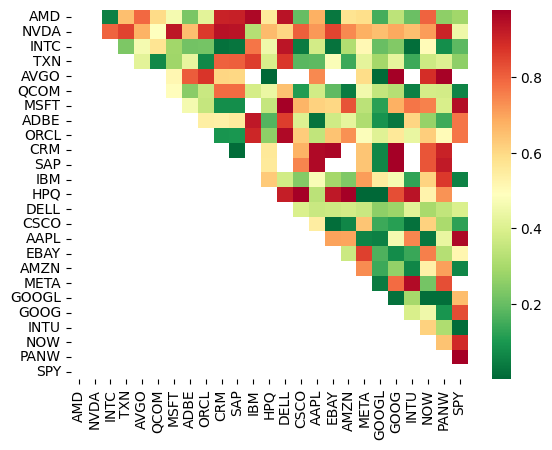

[('AAPL', 'MSFT'), ('AMD', 'GOOG'), ('AMD', 'GOOGL'), ('AMD', 'INTU'), ('AMD', 'MSFT'), ('AMD', 'QCOM'), ('AVGO', 'IBM'), ('AVGO', 'ORCL'), ('CRM', 'NOW'), ('DELL', 'META'), ('DELL', 'PANW'), ('GOOG', 'GOOGL'), ('IBM', 'NVDA'), ('IBM', 'ORCL'), ('INTU', 'MSFT'), ('INTU', 'QCOM'), ('META', 'SAP'), ('NVDA', 'ORCL'), ('ORCL', 'PANW'), ('ORCL', 'SAP'), ('ORCL', 'SPY'), ('QCOM', 'TXN')]


In [95]:
scores,pvalues,pairs=find_coin_pairs(prices)
m=[0,0.2,0.4,0.6,0.8,1]
sns.heatmap(pvalues,xticklabels=tickers,
            yticklabels=tickers,
            cmap='RdYlGn_r',
            mask=(pvalues>=0.98))
plt.show()
print(pairs)

In [96]:
# TO have the top candidates according to thier p-values
candidates = []

for a, b in pairs:
    s1 = df['Adj Close'][a]
    s2 = df['Adj Close'][b]

    score, pvalue, _ = coint(s1, s2)

    candidates.append((a, b, pvalue))

# sort by strength
candidates = sorted(candidates, key=lambda x: x[2])

top_five = candidates[:5]
top_five


[('AVGO', 'IBM', np.float64(0.0007337761053428346)),
 ('IBM', 'NVDA', np.float64(0.0008537519513700345)),
 ('IBM', 'ORCL', np.float64(0.00452425717699637)),
 ('AVGO', 'ORCL', np.float64(0.0068066884162659895)),
 ('GOOG', 'GOOGL', np.float64(0.009002551325432498))]

Looks like quite a few are cointegrated lets look at the TOP 5 prices to make sure nothing weird is going-on.

* AAPL & AMD

p-value: 0.05417948678130286


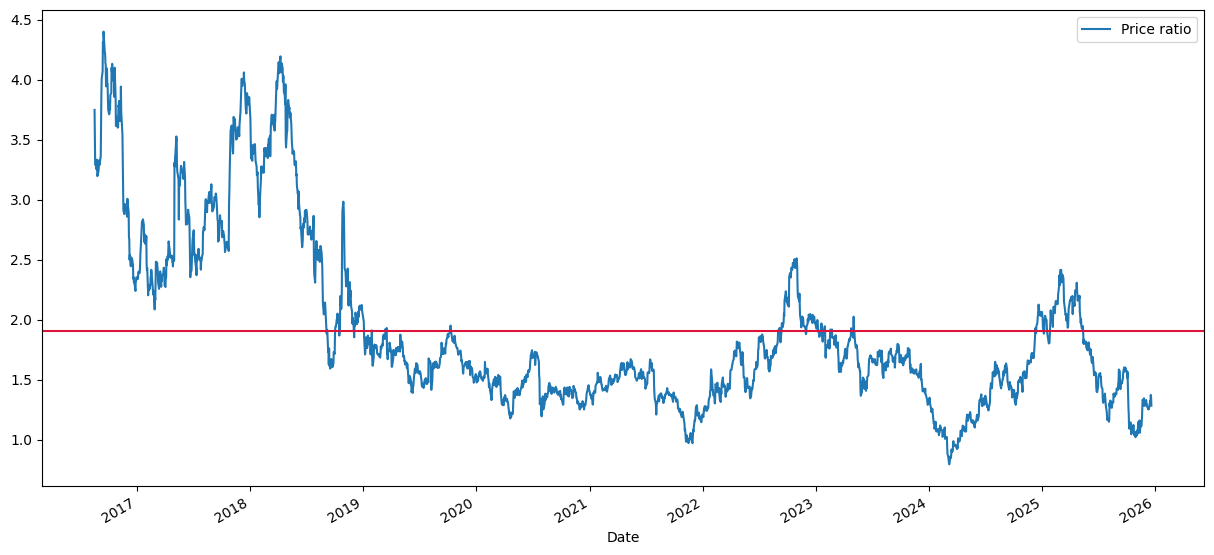

In [97]:
s1=df[('Adj Close','AAPL')]
s2=df[('Adj Close','AMD')]
score,pvalue,_=coint(s1,s2)
print('p-value:',pvalue)
ratio1=s1/s2
ratio1.plot(figsize=(15,7))
plt.axhline(ratio1.mean(),color='crimson')
plt.legend(['Price ratio'])
plt.show()

* AAPL & MSFT

p-value: 0.03391653948674368


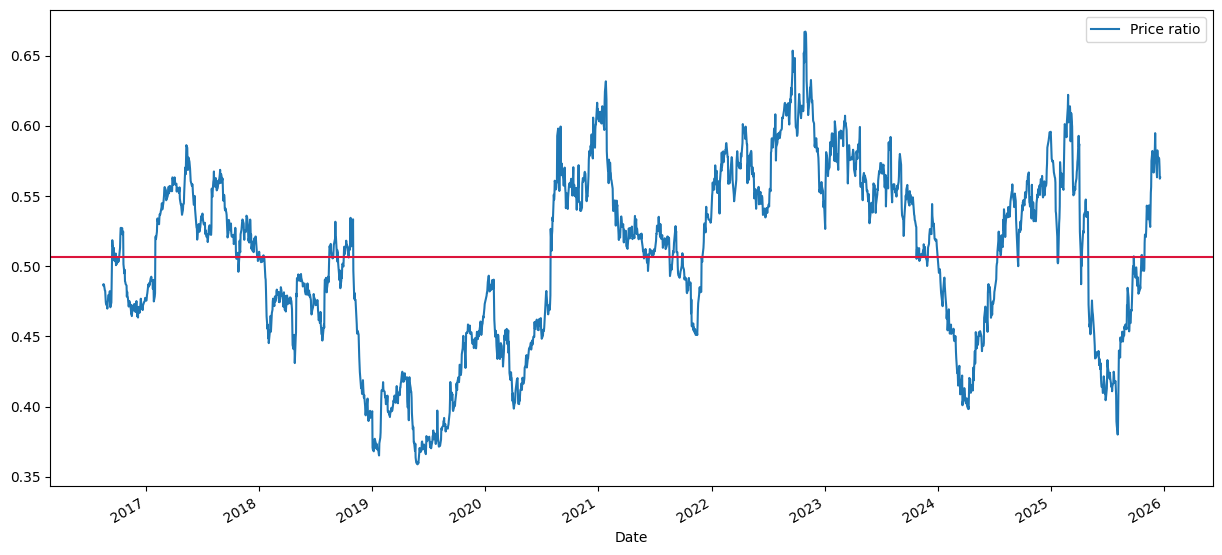

In [98]:
s1=df[('Adj Close','AAPL')]
s2=df[('Adj Close','MSFT')]
score,pvalue,_=coint(s1,s2)
print('p-value:',pvalue)
ratio2=s1/s2
ratio2.plot(figsize=(15,7))
plt.axhline(ratio2.mean(),color='crimson')
plt.legend(['Price ratio'])
plt.show()

* AMD & GOOG

p-value: 0.0233523619250904


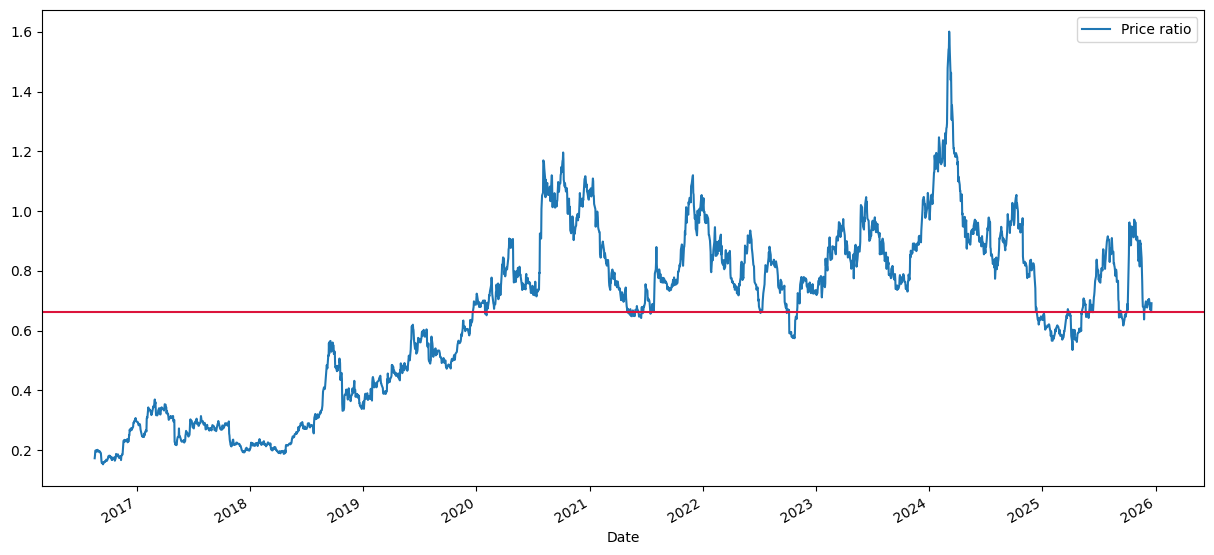

In [99]:
s1=df[('Adj Close','AMD')]
s2=df[('Adj Close','GOOG')]
score,pvalue,_=coint(s1,s2)
print('p-value:',pvalue)
ratio3=s1/s2
ratio3.plot(figsize=(15,7))
plt.axhline(ratio3.mean(),color='crimson')
plt.legend(['Price ratio'])
plt.show()

* AMD & GOOGL

p-value: 0.028294645762098437


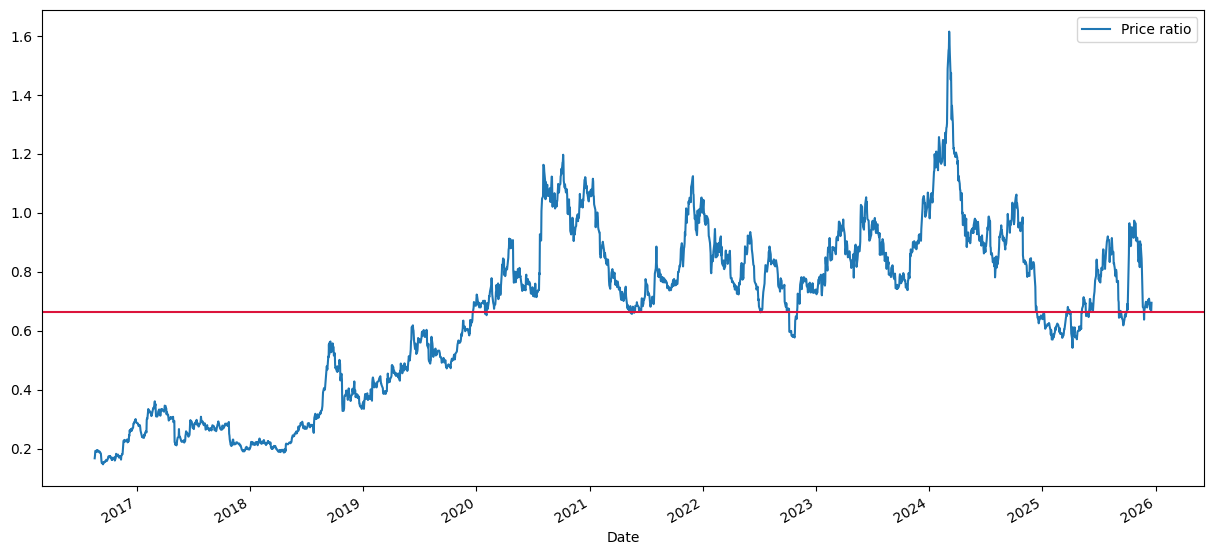

In [100]:
s1=df[('Adj Close','AMD')]
s2=df[('Adj Close','GOOGL')]
score,pvalue,_=coint(s1,s2)
print('p-value:',pvalue)
ratio4=s1/s2
ratio4.plot(figsize=(15,7))
plt.axhline(ratio4.mean(),color='crimson')
plt.legend(['Price ratio'])
plt.show()

* AMD & INTU

p-value: 0.040494529164825134


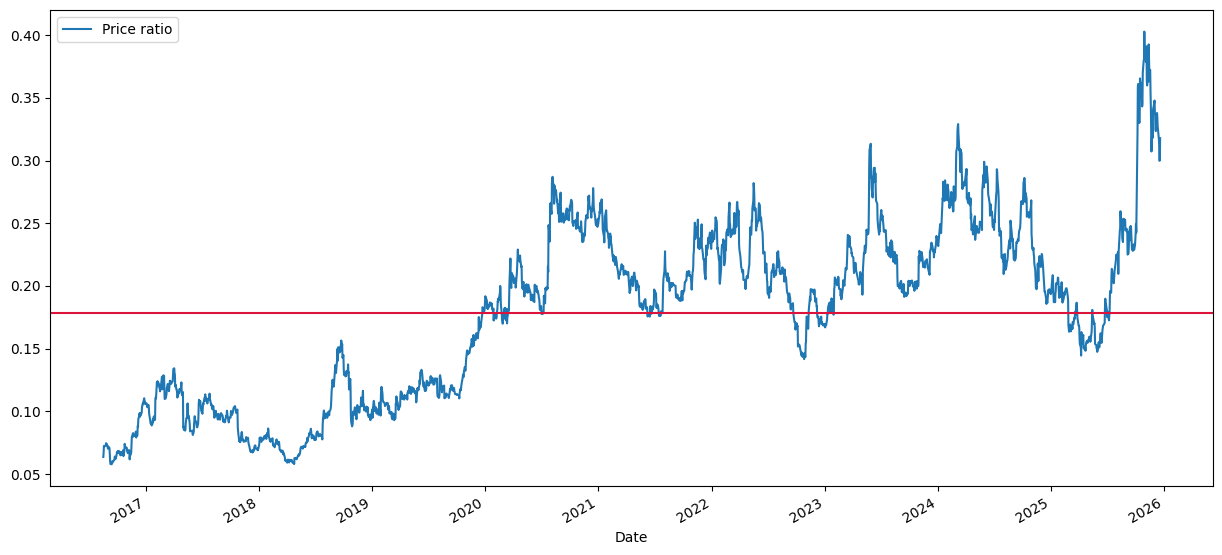

In [101]:
s1=df[('Adj Close','AMD')]
s2=df[('Adj Close','INTU')]
score,pvalue,_=coint(s1,s2)
print('p-value:',pvalue)
ratio5=s1/s2
ratio5.plot(figsize=(15,7))
plt.axhline(ratio5.mean(),color='crimson')
plt.legend(['Price ratio'])
plt.show()

The absolute ratio isn't very useful in statistical terms.
It is more helpful to normalize the signal by treating it as z-score.

##### Z Score(value) = (Value-Mean) / Standard Deviation

In [102]:
def z_score(series):
    return ((series-series.mean())/ np.std(series))

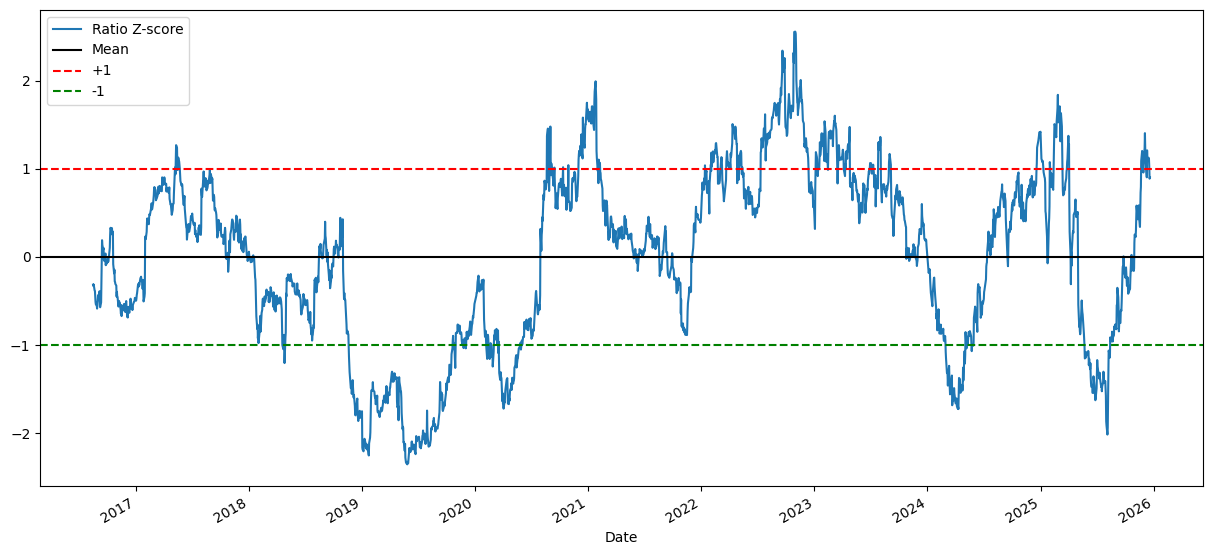

In [103]:
z_score(ratio2).plot(figsize=(15,7))
plt.axhline(z_score(ratio2).mean(),color='black')
plt.axhline(1.0,color='red',linestyle='--')
plt.axhline(-1.0,color='green',linestyle='--')
plt.legend(['Ratio Z-score','Mean','+1','-1'])
plt.show()

Simple strategy:
* Go 'long' the ratio whenever the z-score is below -1.0.
* Go 'short' the ratio when the z-score is above 1.0.
* Exit positions when the z-score approaches zero.

In general, taking a statistic over your whole sample size can be bad.

Instead of using ratio values, let's use 5d MA's to compute to z score, and the 60d MA and 60d SD as the mean and standard deviation.

In [104]:
ratios=prices['AAPL']/prices['MSFT']
print(len(ratios))
train=ratios[:1762]
test=ratios[1762:]

2349


In [105]:
ratios_ma5=train.rolling(window=5,center=False).mean()
ratios_ma60=train.rolling(window=60,center=False).mean()
ratios_sd60=train.rolling(window=60,center=False).std()

In [106]:
z_score_60_5=((ratios_ma5-ratios_ma60)/ratios_sd60)

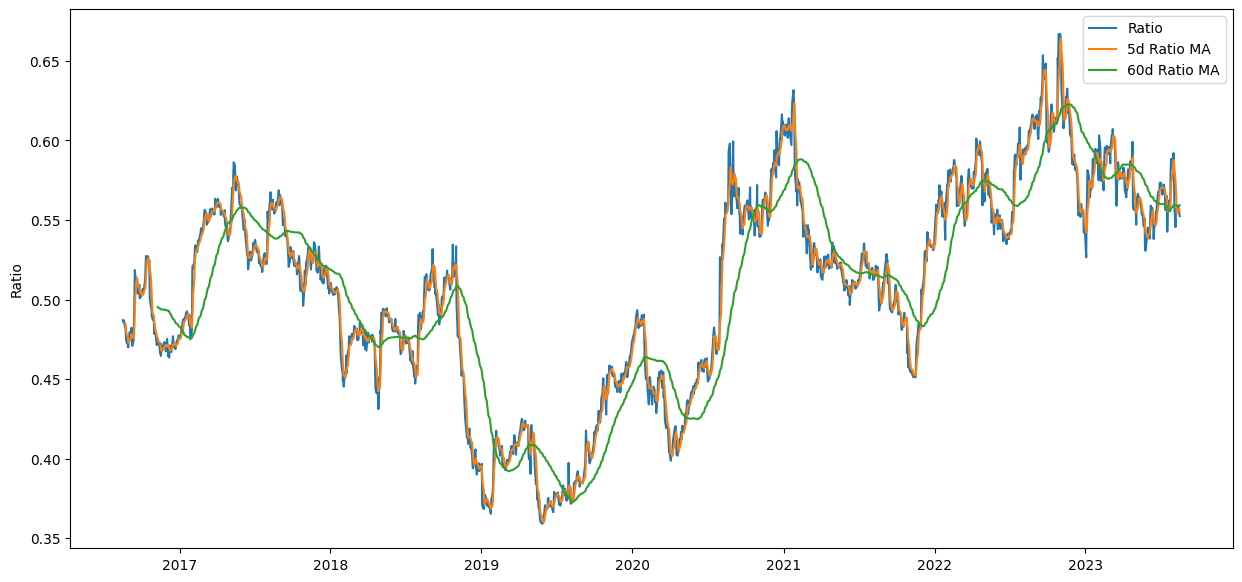

In [107]:
plt.figure(figsize=(15,7))
plt.plot(train.index,train.values)
plt.plot(ratios_ma5.index,ratios_ma5.values)
plt.plot(ratios_ma60.index,ratios_ma60.values)

plt.legend(['Ratio','5d Ratio MA','60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

We can use the MA's to compute the z-score of the ratio at each given time. This will tell us how extreme the ratio is and whether it's a good idea to enter a position at this time.

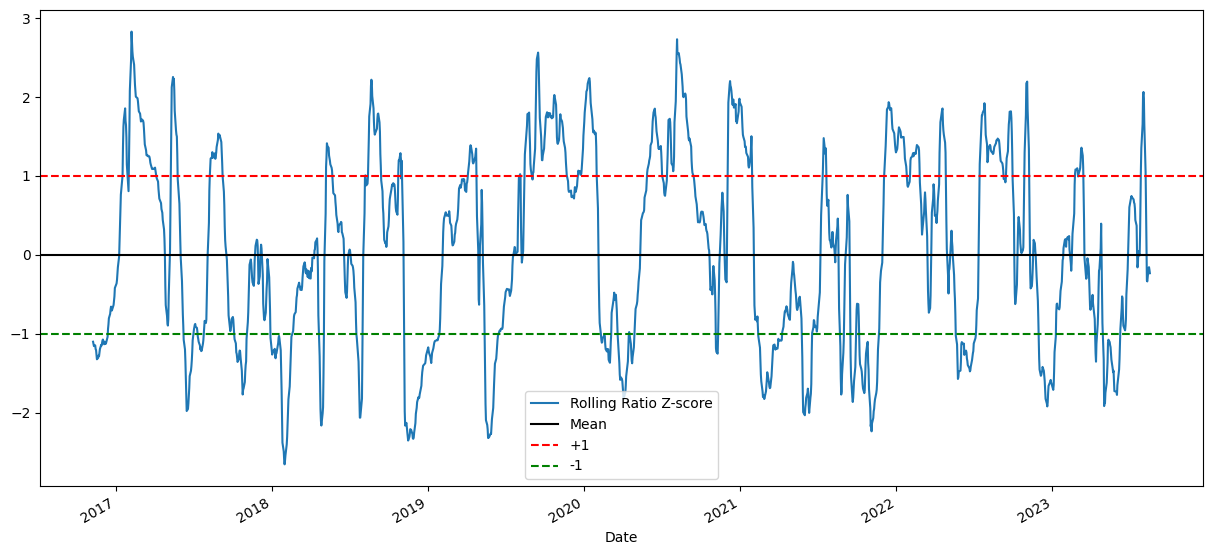

In [108]:
# Taking a rolling 60 day standard deviation
ratios_sd60.name='std 60d'
#compute z-score for each day
z_score_60_5.name='z-score'

plt.figure(figsize=(15,7))
z_score_60_5.plot()
plt.axhline(0,color='black')
plt.axhline(1.0,color='red',linestyle='--')
plt.axhline(-1.0,color='green',linestyle='--')
plt.legend(['Rolling Ratio Z-score','Mean','+1','-1'])
plt.show()

Z-score doesn't mean much out of context but lets plot it next to prices to see what it looks like.

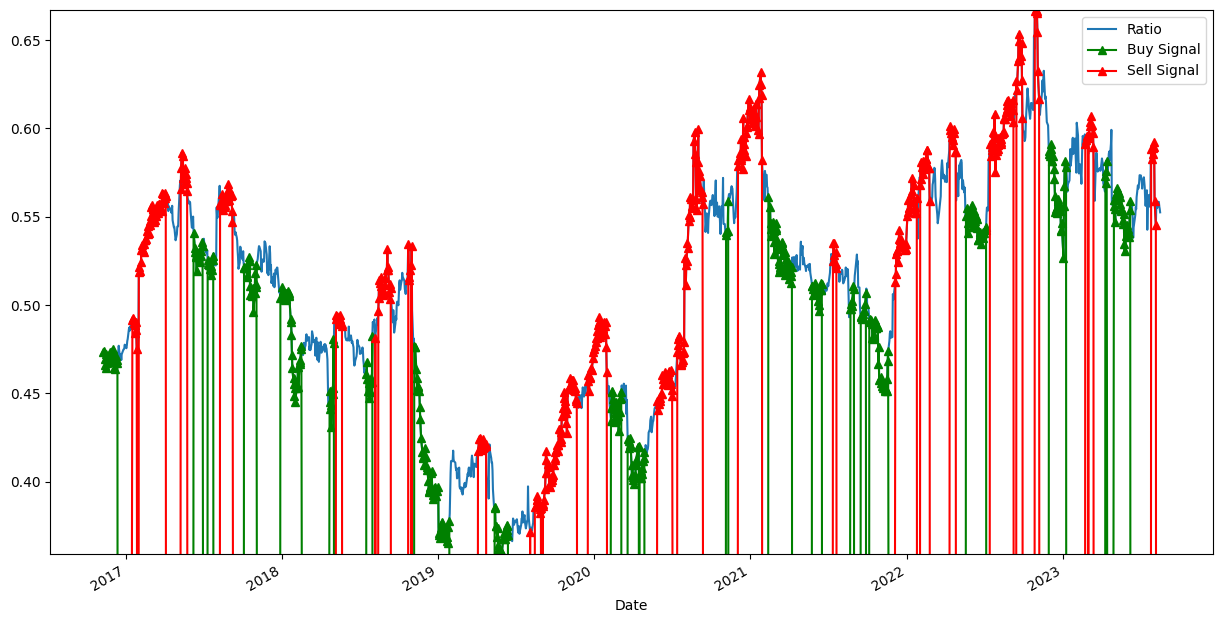

In [109]:
# plotting the ratios and buy and sell signals from z-score
plt.figure(figsize=(15,8))

train[60:].plot()
buy=train.copy()
sell=train.copy()
buy[z_score_60_5>-1]=0
sell[z_score_60_5<1]=0
buy[60:].plot(color='green',marker='^')
sell[60:].plot(color='red',marker='^')
x1,x2,y1,y2=plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio','Buy Signal','Sell Signal'])
plt.show()


What does this mean for the actual trades, let's see...

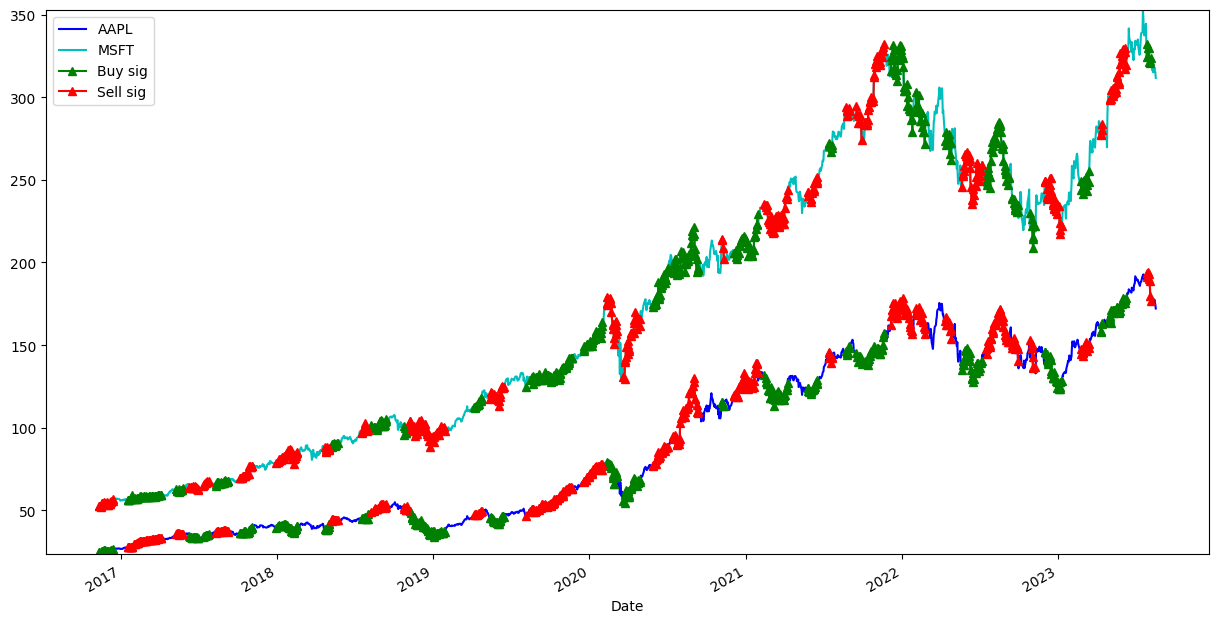

In [110]:
#plot the prices and buy and sell signals from z-scores
plt.figure(figsize=(15,8))
s1=prices['AAPL'].iloc[:1762]
s2=prices['MSFT'].iloc[:1762]
s1[60:].plot(color='b')
s2[60:].plot(color='c')
buyr=np.nan*s1.copy()
sellr=np.nan*s1.copy()
# when buying the ratio, buy s1 and sell s2
buyr[buy!=0]=s1[buy!=0]
sellr[buy!=0]=s2[buy!=0]
# when sellig the ratio, sell s1 and buy s2
buyr[sell!=0]=s2[sell!=0]
sellr[sell!=0]=s1[sell!=0]

buyr[60:].plot(color='green',marker='^')
sellr[60:].plot(color='red',marker='^')
x1,x2,y1,y2=plt.axis()
plt.axis((x1,x2,min(s1.min(),s2.min()),max(s1.max(),s2.max())))
plt.legend(['AAPL','MSFT','Buy sig','Sell sig'])
plt.show()

In [ ]:
def trade(s1,s2,window1,window2):
    if (window1==0) or (window2==0):
        return 0
    #compute rolling mean and rolling std
    Ratios=s1/s2
    ma1=Ratios.rolling(window=window1,center=False).mean()
    ma2=Ratios.rolling(window=window2,center=False).mean()
    std=Ratios.rolling(window=window2,center=False).std()
    zscore=(ma1-ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for t in zscore.index:
     if np.isnan(zscore.loc[t]):
        continue

     if zscore.loc[t] > 1:
        money += s1.loc[t] - s2.loc[t] * ratios.loc[t]
        countS1 -= 1
        countS2 += ratios.loc[t]

     elif zscore.loc[t] < -1:
        money -= s1.loc[t] - s2.loc[t] * ratios.loc[t]
        countS1 += 1
        countS2 -= ratios.loc[t]

     elif abs(zscore.loc[t]) < 0.5:
        money += countS1 * s1.loc[t] + countS2 * s2.loc[t]
        countS1 = 0
        countS2 = 0
    return money

In [118]:
trade(prices['AAPL'].iloc[:1762],prices['MSFT'].iloc[:1762],60,5)

np.float64(-1753.8836784212363)